## This notebook checks if SCAE is required for artifact detection in ABP.

Trains the CNN without SCAE, architecture of CNN is slightly different than that of the paper, it is not larger.

In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

from CustomDatasets import SCAEDataset
from Models import testCNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
train_dataset = SCAEDataset(root_dir="../data/train")
val_dataset = SCAEDataset(root_dir="../data/val")
test_dataset = SCAEDataset(root_dir="../data/test")

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)

In [3]:
model = testCNN()
print(model)

testCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [4]:
## Verifying sizes of each layer outputs
dummy_input = torch.randn(32, 1, 64, 64)

# Function to calculate the size of each layer's output
def calculate_layer_sizes(model, dummy_input):
    layer_sizes = []
    x = dummy_input
    for layer in model.children():
        x = layer(x)
        print(layer, x.shape)

        if isinstance(layer, nn.Flatten):
            layer_sizes.append(x.shape[1])  # After flattening, x is a 1D tensor
        else:
            layer_sizes.append(x.size())
    return layer_sizes

layer_sizes = calculate_layer_sizes(model, dummy_input)
layer_sizes

Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) torch.Size([32, 8, 64, 64])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([32, 8, 32, 32])
Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) torch.Size([32, 16, 32, 32])
Flatten(start_dim=1, end_dim=-1) torch.Size([32, 16384])
Linear(in_features=16384, out_features=120, bias=True) torch.Size([32, 120])
Linear(in_features=120, out_features=84, bias=True) torch.Size([32, 84])
Linear(in_features=84, out_features=2, bias=True) torch.Size([32, 2])


[torch.Size([32, 8, 64, 64]),
 torch.Size([32, 8, 32, 32]),
 torch.Size([32, 16, 32, 32]),
 16384,
 torch.Size([32, 120]),
 torch.Size([32, 84]),
 torch.Size([32, 2])]

In [4]:
# Train the CNN
# Define the loss function and optimizer
train_loss_arr, val_loss_arr = [],[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

num_epochs = 100  # Number of training epochs
best_val_loss = float('inf')  # Track the best validation loss

# Training and Validation
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')
    
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
    
    train_loss_arr.append(avg_train_loss)
    val_loss_arr.append(avg_val_loss)
    
    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.4f}--->{avg_val_loss:.4f}) \t Saving The Model')
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '../models/CNN_best_model.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.1831
Epoch 1, Validation Loss: 0.1486
Validation Loss Decreased(inf--->0.1486) 	 Saving The Model
Epoch 2, Train Loss: 0.1298
Epoch 2, Validation Loss: 0.1296
Validation Loss Decreased(0.1486--->0.1296) 	 Saving The Model
Epoch 3, Train Loss: 0.1131
Epoch 3, Validation Loss: 0.1444
Epoch 4, Train Loss: 0.0942
Epoch 4, Validation Loss: 0.1381
Epoch 5, Train Loss: 0.0806
Epoch 5, Validation Loss: 0.1642
Epoch 6, Train Loss: 0.0646
Epoch 6, Validation Loss: 0.1567
Epoch 7, Train Loss: 0.0516
Epoch 7, Validation Loss: 0.1773
Epoch 8, Train Loss: 0.0436
Epoch 8, Validation Loss: 0.1924
Epoch 9, Train Loss: 0.0373
Epoch 9, Validation Loss: 0.2159
Epoch 10, Train Loss: 0.0275
Epoch 10, Validation Loss: 0.2279
Epoch 11, Train Loss: 0.0249
Epoch 11, Validation Loss: 0.2252
Epoch 12, Train Loss: 0.0216
Epoch 12, Validation Loss: 0.2417
Epoch 13, Train Loss: 0.0184
Epoch 13, Validation Loss: 0.2563
Epoch 14, Train Loss: 0.0189
Epoch 14, Validation Loss: 0.2324
Epoch 15, Tra

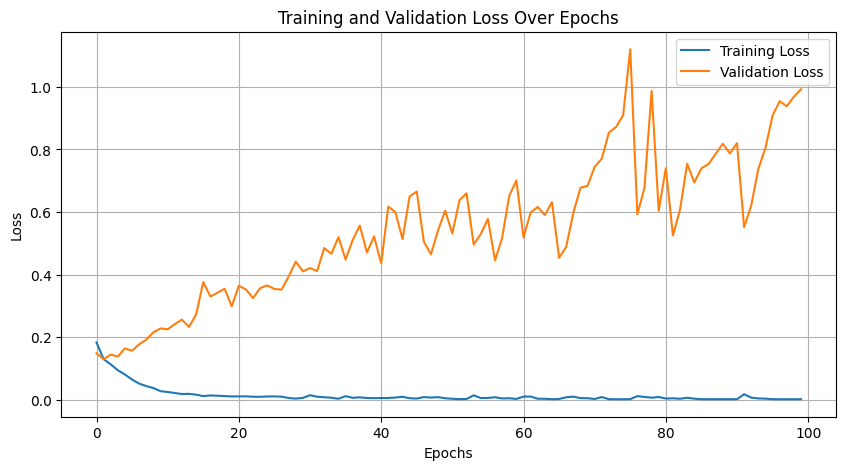

In [5]:
import matplotlib.pyplot as plt
# Plotting both training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_arr, label='Training Loss')
plt.plot(val_loss_arr, label='Validation Loss')

# Labeling the graph
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Load the best performing model
model.load_state_dict(torch.load('../models/CNN_best_model.pth'))

<All keys matched successfully>

In [11]:
def evaluate_model(model, loader):
    # Ensure the model is in evaluation mode
    actual_labels = []
    predicted_labels = []
    
    model.eval()

    # Disable gradient calculation for efficiency and to prevent changes to the model
    with torch.no_grad():
        correct = 0
        total = 0
        
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert outputs probabilities to predicted class
            _, predicted = torch.max(outputs.data, 1)
            
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            actual_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())
    
    return actual_labels, predicted_labels


In [12]:
actual, predicted = evaluate_model(model, test_loader)

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# Calculate Accuracy
accuracy = accuracy_score(actual, predicted)

# Calculate F1 Score: F1 Score is the weighted average of Precision and Recall.
f1 = f1_score(actual, predicted)

# Calculate G-Score: G-Score is the geometric mean of Precision and Sensitivity (Recall).
precision = precision_score(actual, predicted)
sensitivity = recall_score(actual, predicted)  # Also known as Recall
g_score = (precision * sensitivity)**0.5

# Calculate Net Prediction: (True Positives - False Positives) / Total Predictions
true_positives = sum((a == 1 and p == 1) for a, p in zip(actual, predicted))
false_positives = sum((a == 0 and p == 1) for a, p in zip(actual, predicted))
net_prediction = (true_positives - false_positives) / len(predicted)

# Calculate Specificity: True Negative Rate
true_negatives = sum((a == 0 and p == 0) for a, p in zip(actual, predicted))
specificity = true_negatives / sum(a == 0 for a in actual)

accuracy, f1, g_score , sensitivity, specificity

(0.960234474017744,
 0.9602533650039589,
 0.9602534733596471,
 0.9607097591888466,
 0.9597591888466414)

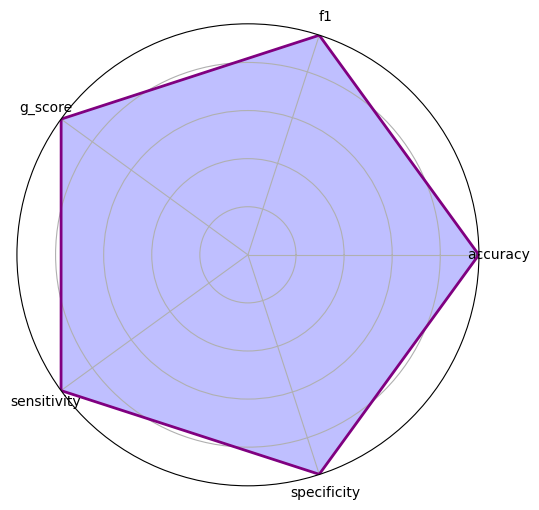

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
labels=np.array(['accuracy', 'f1', 'g_score' , 'sensitivity', 'specificity'])
stats=np.array([accuracy, f1, g_score , sensitivity, specificity])

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
# and append the start value to the end.
stats=np.concatenate((stats,[stats[0]]))
angles+=angles[:1]

# Draw the outline of our data
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='blue', alpha=0.25)
ax.plot(angles, stats, color='purple', linewidth=2)

# Label each point with its variable name
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.show()

In [15]:
for metric, value in zip(labels, stats):
    print(f"{metric}: {value}")

accuracy: 0.960234474017744
f1: 0.9602533650039589
g_score: 0.9602534733596471
sensitivity: 0.9607097591888466
specificity: 0.9597591888466414
